# 2-Cell and 3-Cell Motifs in PyC Subgraph (Th=100)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

## Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [3]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [4]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [5]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [6]:
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [7]:
g_th100 = get_thresholded_graph(g_actual, axls, 100)
print(nx.info(g_th100))

Name: 
Type: DiGraph
Number of nodes: 113
Number of edges: 666
Average in degree:   5.8938
Average out degree:   5.8938


## 2-Cell Motifs

In [8]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_th100)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_th100)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.86 ms


In [9]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_th100, samples=s, niters=int(1e4), threads=10)

CPU times: user 68 ms, sys: 72 ms, total: 140 ms
Wall time: 37.1 s


connect probability =  0.052623261694058156


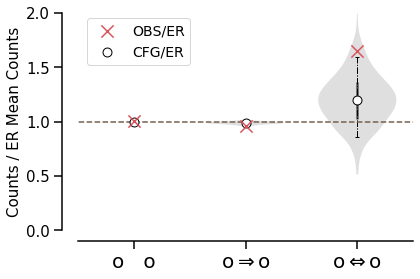

In [10]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2), fname="th100/th100_2_violin");

In [11]:
res_two

,obs,er_exp,config_exp,config_std,config_z
actual_edges,NaN,NaN,666.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,29.0,17.523546,21.068,4.167342,1.903371
neurons,NaN,NaN,113.000,0.000000,NaN
null,5691.0,5679.523546,5683.068,4.167342,1.903371
potential_edges,NaN,NaN,12656.000,0.000000,NaN
uni,608.0,630.952908,623.864,8.334685,-1.903371


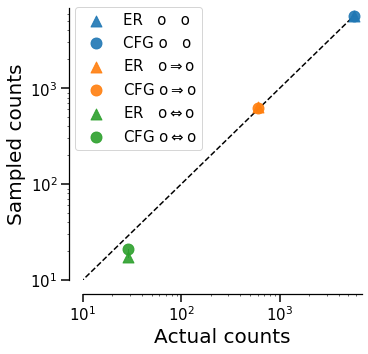

In [12]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="th100/th100_2_scatter")

In [13]:
# p-values
np.minimum((config_two_counts > obs_two_counts).sum(0) / 1000, 
           (config_two_counts < obs_two_counts).sum(0) / 1000)

neurons            0.000
autapses           0.000
actual_edges       0.000
uni                0.025
bi                 0.025
potential_edges    0.000
null               0.025
dtype: float64

## 3-Cell Motifs

In [14]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_th100), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_th100)
er_three_counts = compute_expected_three_neuron_motifs(g_th100, three_pr)

CPU times: user 15 s, sys: 20 ms, total: 15 s
Wall time: 15 s


In [15]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_th100, samples=s, niters=int(1e4), threads=10)

CPU times: user 172 ms, sys: 48 ms, total: 220 ms
Wall time: 45min 35s


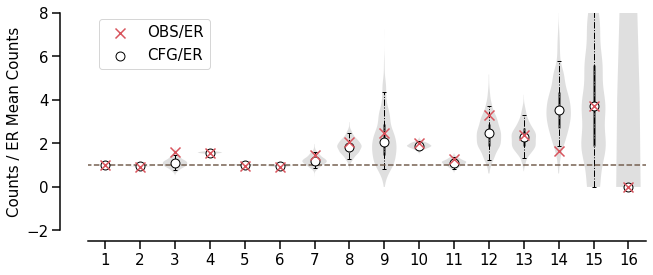

In [16]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 8], fname="th100/th100_3_violin", figsize=(10,4))

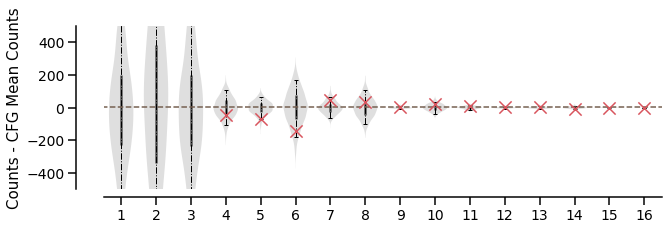

In [17]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="th100/th100_3_violin_diff");

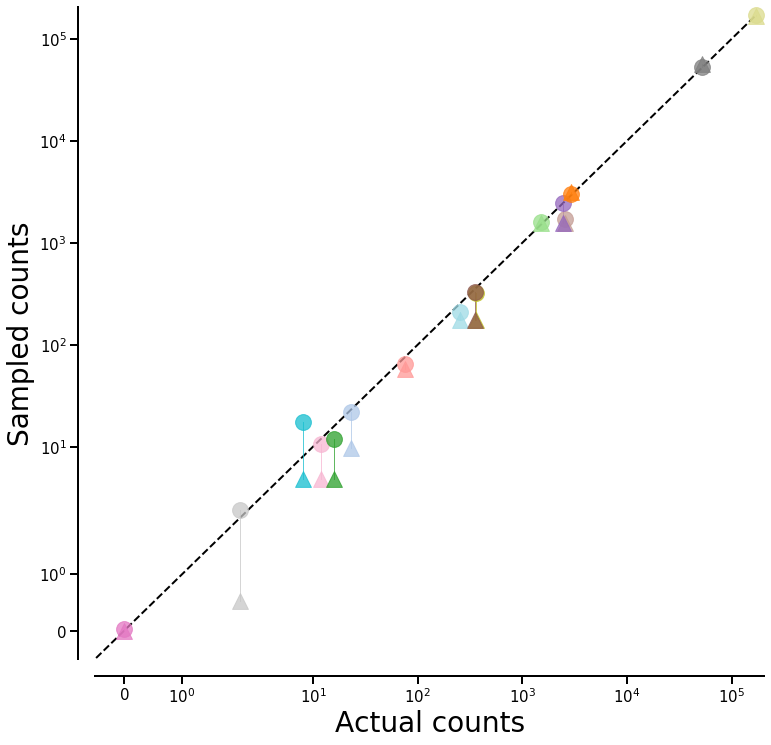

In [18]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="th100/th100_3_scatter")

In [19]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,171860,169279.550143,171093.292,321.310705,2.386189
2,51793,56417.104451,53219.045,551.481505,-2.585844
3,2531,1566.880382,1722.316,331.057142,2.442732
4,2436,1566.880382,2482.136,65.793878,-0.701220
5,1521,1566.880382,1590.571,41.569327,-1.673614
6,2891,3133.760764,3035.775,106.640314,-1.357601
7,255,174.068780,210.381,39.099752,1.141158
8,358,174.068780,323.174,62.093569,0.560863
9,12,4.834437,10.585,5.268637,0.268570
10,355,174.068780,330.426,22.249215,1.104488


In [69]:
# p-values
np.minimum((config_three_counts > obs_three_counts).sum(0) / 1000, 
           (config_three_counts < obs_three_counts).sum(0) / 1000)

1     0.014
2     0.008
3     0.011
4     0.238
5     0.048
6     0.094
7     0.132
8     0.281
9     0.298
10    0.131
11    0.117
12    0.109
13    0.379
14    0.029
15    0.362
16    0.000
dtype: float64

## 3-Cell Motifs (Generalized ER and CFG)

In [21]:
%%time
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th100)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_th100, three_pr_GE)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 659 µs


In [22]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_th100, samples=s, niters=int(1e4), threads=10)

CPU times: user 156 ms, sys: 56 ms, total: 212 ms
Wall time: 45min 14s


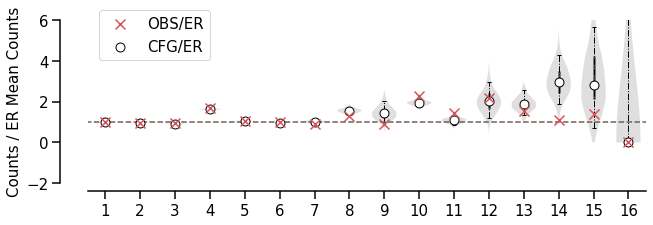

In [23]:
# relative counts in ratio (/ER expected counts)
res_three_GE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                            subtitle='', ylim=[-2, 6], fname="th100/th100_3_violin_GE", figsize=(10,3))

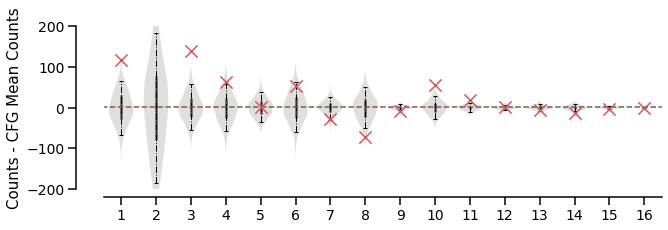

In [24]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                     subtitle='', ylim=[-200, 200], fname="th100/th100_3_violin_diff_GE");

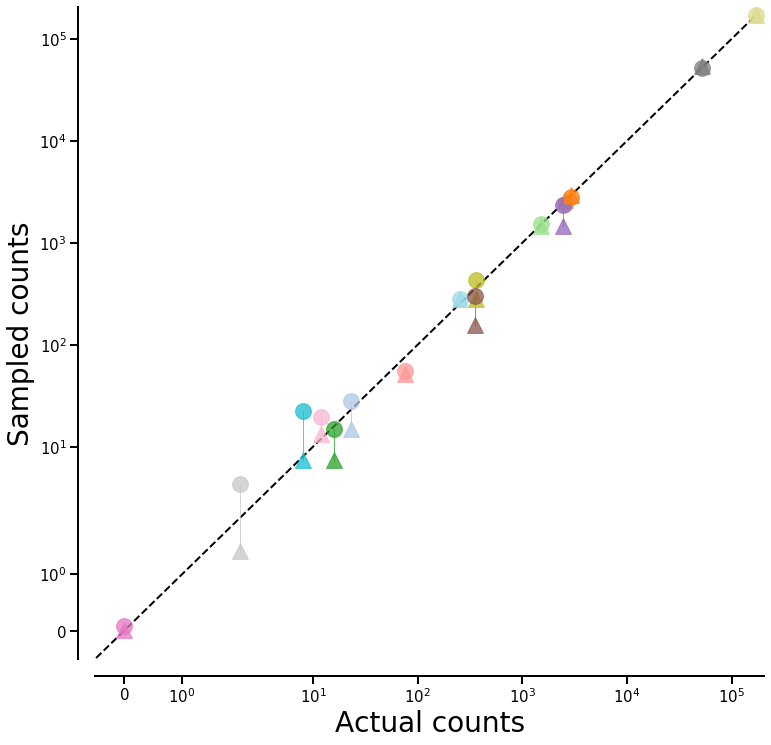

In [25]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                 figsize=(12,12), fname="th100/th100_3_scatter_GE")

In [26]:
res_three_GE

,obs,er_exp,config_exp,config_std,config_z
1,171860,170307.800414,171742.093,40.648550,2.900645
2,51793,54584.682473,52113.649,113.254149,-2.831234
3,2531,2603.545710,2393.242,33.817881,4.073525
4,2436,1457.893470,2372.428,35.722275,1.779618
5,1521,1457.893470,1518.898,22.601514,0.093003
6,2891,2915.786939,2837.376,37.210445,1.441101
7,255,278.150728,281.934,17.094147,-1.575627
8,358,278.150728,430.989,30.896917,-2.362339
9,12,13.267058,19.314,4.491278,-1.628490
10,355,155.754565,300.698,17.091604,3.177116


In [71]:
# p-values
np.minimum((config_three_counts_GE > obs_three_counts).sum(0) / 1000, 
           (config_three_counts_GE < obs_three_counts).sum(0) / 1000)

1     0.002
2     0.002
3     0.000
4     0.035
5     0.460
6     0.077
7     0.063
8     0.006
9     0.024
10    0.000
11    0.005
12    0.324
13    0.143
14    0.000
15    0.075
16    0.000
dtype: float64

## Clustering Coefficient

In [28]:
# clustering coefficient of the observed network
nx.transitivity(g_th100.to_undirected())

0.16127946127946127

In [29]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.10247731571679497

In [30]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.14957100383560884

In [31]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.10066371681415931

In [32]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.14626042082816113

## CFG v.s. Generalized ER

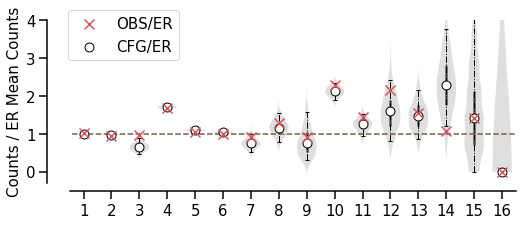

In [67]:
# relative counts in ratio (/ER expected counts)
res_three_CGE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-0.3, 4], fname="th100/th100_3_violin_CGE", figsize=(8,3))

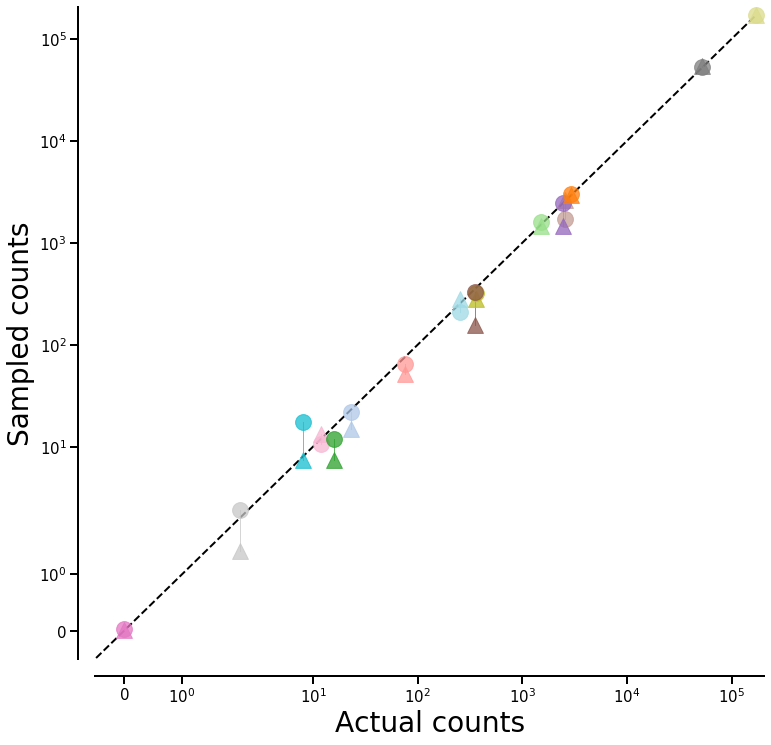

In [35]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(12,12), fname="th100/th100_3_scatter_CGE")

## More Comparison

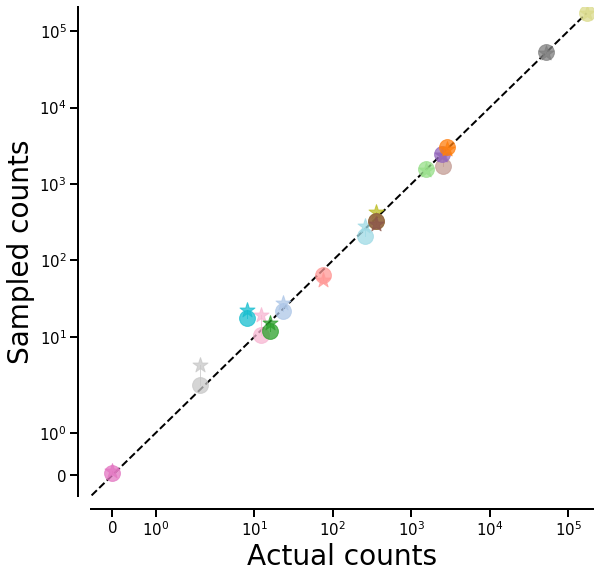

In [61]:
plot_three_neuron_counts_scatter_adapt(obs_three_counts, config_three_counts.mean(0), config_three_counts_GE.mean(0), 
                                 figsize=(9,9), fname="th100/th100_3_scatter_C-GC")

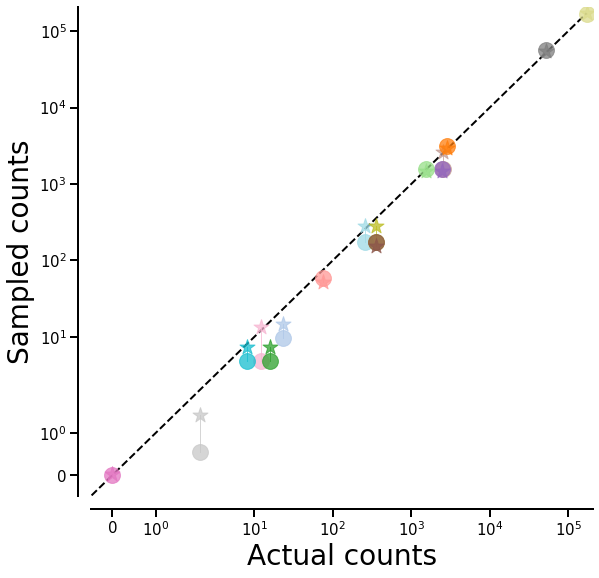

In [62]:
plot_three_neuron_counts_scatter_adapt(obs_three_counts, er_three_counts, er_three_counts_GE, 
                                 figsize=(9,9), fname="th100/th100_3_scatter_E-GE")

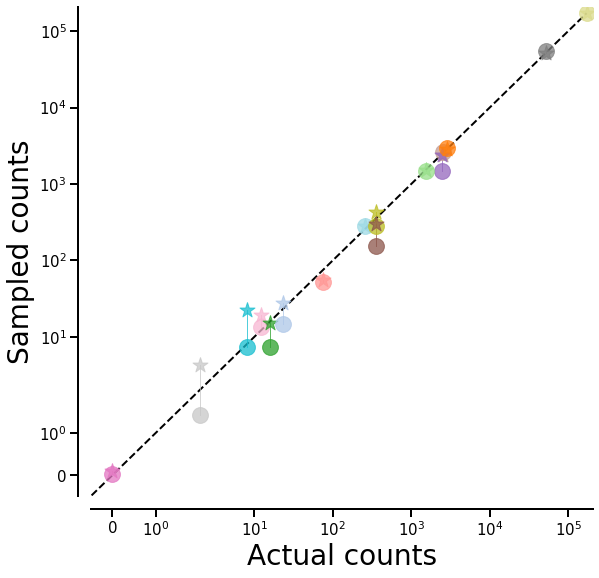

In [63]:
plot_three_neuron_counts_scatter_adapt(obs_three_counts, er_three_counts_GE, config_three_counts_GE.mean(0), 
                                 figsize=(9,9), fname="th100/th100_3_scatter_GC-GE")